# Model vs. Observations scatter plots


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
# from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import glob
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [160]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.04, 'tol_lat': 0.0388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012},
        }
):

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # Added by BMM March 2017
        # If including points outside of domain:
        return np.nan, np.nan
        # raise ValueError(
        #    'No model point found. tol_lon/tol_lat too small or '
        #    'lon/lat outside of domain.')
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest

        # Avoiding array indexing because some functions
        # pass in model_lons and model_lats as netcdf4 objects
        # (which treat 'model_lons[j_list, i_list]' differently)
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


In [3]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [4]:
def search_depth(obs_depth, model_depths):
    k_list = np.array([])
    for i in range(0,len(obs_depth)):
        diff_list = np.array([])
        for n in range(0, len(model_depths)):
            diff = np.abs(obs_depth[i] - model_depths[n])
            diff_list = np.append(diff_list, diff)
        k = np.argmin(diff_list) # for list of indices associated with depths
        k_list = np.append(k_list, k)
    return k_list

## Load model results

In [6]:
Mn_model = nc.Dataset('/data/brogalla/run_storage/spin-up3-low-case/ANHA12_EXH006_2002_monthly.nc')
mn_dis = Mn_model.variables['dissolmn']
mn_dis = np.array(mn_dis[:,0,:,:,:])

In [9]:
c = nc.Dataset('/data/brogalla/run_storage/spin-up3-low-case/ANHA12_EXH006_2002_monthly.nc','r')

# Load structure from sample dataset:
lat_model = c.variables['nav_lat']
lon_model = c.variables['nav_lon']
depths_model = c.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

## Load GEOTRACES observations

In [10]:
Mn_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

In [11]:
dMn_BB1 = Mn_data['BB1'].dropna()[1:].astype('float').values
dMn_BB2 = Mn_data['BB2'].dropna()[1:].astype('float').values
dMn_BB3 = Mn_data['BB3'].dropna()[1:].astype('float').values
dMn_CB1 = Mn_data['CB1'].dropna()[1:].astype('float').values
dMn_CB2 = Mn_data['CB2'].dropna()[1:].astype('float').values
dMn_CB3 = Mn_data['CB3'].dropna()[1:].astype('float').values
dMn_CB4 = Mn_data['CB4'].dropna()[1:].astype('float').values
dMn_CAA1 = Mn_data['CAA1'].dropna()[1:].astype('float').values
dMn_CAA2 = Mn_data['CAA2'].dropna()[1:].astype('float').values
dMn_CAA3 = Mn_data['CAA3'].dropna()[1:].astype('float').values
dMn_CAA4 = Mn_data['CAA4'].dropna()[1:].astype('float').values
dMn_CAA5 = Mn_data['CAA5'].dropna()[1:].astype('float').values
dMn_CAA6 = Mn_data['CAA6'].dropna()[1:].astype('float').values
dMn_CAA7 = Mn_data['CAA7'].dropna()[1:].astype('float').values
dMn_CAA8 = Mn_data['CAA8'].dropna()[1:].astype('float').values
dMn_CAA9 = Mn_data['CAA9'].dropna()[1:].astype('float').values

In [12]:
depth_BB1 = Mn_data['Depth.2'].dropna().values
depth_BB2 = Mn_data['Depth.3'].dropna().values
depth_BB3 = Mn_data['Depth.4'].dropna().values
depth_CB1 = Mn_data['Depth.14'].dropna().values
depth_CB2 = Mn_data['Depth.15'].dropna().values
depth_CB3 = Mn_data['Depth.16'].dropna().values
depth_CB4 = Mn_data['Depth.17'].dropna().values
depth_CAA1 = Mn_data['Depth.5'].dropna().values
depth_CAA2 = Mn_data['Depth.6'].dropna().values
depth_CAA3 = Mn_data['Depth.7'].dropna().values
depth_CAA4 = Mn_data['Depth.8'].dropna().values
depth_CAA5 = Mn_data['Depth.9'].dropna().values
depth_CAA6 = Mn_data['Depth.10'].dropna().values
depth_CAA7 = Mn_data['Depth.11'].dropna().values
depth_CAA8 = Mn_data['Depth.12'].dropna().values
depth_CAA9 = Mn_data['Depth.13'].dropna().values

In [13]:
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].astype('str').dropna()
lons = Pb_data['station lon'].astype('float').dropna()
lats = Pb_data['Station lat'].astype('float').dropna()

# Find pairings

In [14]:
station_lons = lons.values
station_lats = lats.values
station_name = stn_names.values

In [15]:
# find coordinates near the lat/lon of the stations:
station_is = np.array([])
station_js = np.array([])
for k in range(0,len(station_lons)):
    i, j = find_closest_model_point(station_lons[k], station_lats[k], lon_model, lat_model)
    station_is = np.append(station_is, i)
    station_js = np.append(station_js, j)

In [16]:
station_i = station_is[np.isnan(station_is)==False]
station_j = station_js[np.isnan(station_js)==False]
station_ns = station_name[0:len(station_is)]
station_n = station_ns[np.isnan(station_is)==False]

In [17]:
station_i = [int(i) for i in station_i]
station_j = [int(j) for j in station_j]

dMn_model:

In [18]:
model_mn_dis = mn_dis[8,:,:,:]

In [19]:
stn_model_dmn = model_mn_dis[:,station_i[0],station_j[0]]
for i in range(1,len(station_i)):
    stn_mdmn = model_mn_dis[:,station_i[i],station_j[i]]
    stn_model_dmn = np.vstack((stn_mdmn, stn_model_dmn))

Observations:

In [20]:
def match_depth(depths_stn, depths_model=depths_model):
    depth_k  = search_depth(depths_stn, depths_model)
    
    depths_return=np.array([])
    # depths that I'm interested in for the RI & Willmott index:
    for i in range(0, len(depth_k)):
        if depth_k[i] > 0:
            depths_return =np.append(depths_return, depth_k[i])
            
    depths_return  = [int(k) for k in depths_return]
    return depths_return

In [21]:
k_CAA1 = match_depth(depth_CAA1)
k_CAA2 = match_depth(depth_CAA2)
k_CAA3 = match_depth(depth_CAA3)
k_CAA4 = match_depth(depth_CAA4)
k_CAA5 = match_depth(depth_CAA5)
k_CAA6 = match_depth(depth_CAA6)
k_CAA7 = match_depth(depth_CAA7)
k_CAA8 = match_depth(depth_CAA8)
k_CAA9 = match_depth(depth_CAA9)

k_CB1 = match_depth(depth_CB1)
k_CB2 = match_depth(depth_CB2)
k_CB3 = match_depth(depth_CB3)

Match closest depths:

In [22]:
model_depth_CAA1 = [depths_model[k] for k in k_CAA1]
model_depth_CAA2 = [depths_model[k] for k in k_CAA2]
model_depth_CAA3 = [depths_model[k] for k in k_CAA3]
model_depth_CAA4 = [depths_model[k] for k in k_CAA4]
model_depth_CAA5 = [depths_model[k] for k in k_CAA5]
model_depth_CAA6 = [depths_model[k] for k in k_CAA6]
model_depth_CAA7 = [depths_model[k] for k in k_CAA7]
model_depth_CAA8 = [depths_model[k] for k in k_CAA8]
model_depth_CAA9 = [depths_model[k] for k in k_CAA9]
model_depth_CB1 = [depths_model[k] for k in k_CB1]
model_depth_CB2 = [depths_model[k] for k in k_CB2]
model_depth_CB3 = [depths_model[k] for k in k_CB3]

In [23]:
model_dmn_CAA1 = np.array([stn_model_dmn[0,k]*10**9 for k in k_CAA1])
model_dmn_CAA2 = np.array([stn_model_dmn[1,k]*10**9 for k in k_CAA2])
model_dmn_CAA3 = np.array([stn_model_dmn[2,k]*10**9 for k in k_CAA3])
model_dmn_CAA4 = np.array([stn_model_dmn[3,k]*10**9 for k in k_CAA4])
model_dmn_CAA5 = np.array([stn_model_dmn[4,k]*10**9 for k in k_CAA5])
model_dmn_CAA6 = np.array([stn_model_dmn[5,k]*10**9 for k in k_CAA6])
model_dmn_CAA7 = np.array([stn_model_dmn[6,k]*10**9 for k in k_CAA7])
model_dmn_CAA8 = np.array([stn_model_dmn[7,k]*10**9 for k in k_CAA8])
model_dmn_CAA9 = np.array([stn_model_dmn[8,k]*10**9 for k in k_CAA9])
model_dmn_CB1  = np.array([stn_model_dmn[9,k]*10**9 for k in k_CB1])
model_dmn_CB2  = np.array([stn_model_dmn[10,k]*10**9 for k in k_CB2])
model_dmn_CB3  = np.array([stn_model_dmn[11,k]*10**9 for k in k_CB3])

# Model vs. Observation scatter plots

In [24]:
station_colors = ['#1e6047', '#36ad80', '#6bd2db', '#0ea7b5', '#0c457d', '#836ca1', \
                  '#99cc19', '#d1e277', '#f5da5f', '#ffa550', '#ff760d', '#b03060']

In [25]:
def willmott_score(Obs, Pred):
    N = np.count_nonzero(~np.isnan(Obs))
    
    numerator   = np.nanmean([(Pred[i]-Obs[i])**2 for i in range(0,N-1)])
    term1       = np.abs(Pred - np.nanmean(Pred))
    term2       = np.abs(Obs - np.nanmean(Obs))
    denominator = np.nanmean([(term1[i]+term2[i])**2 for i in range(0,N-1)])
    deviation   = numerator / denominator
    
    willmott    = 1 - deviation
#     print('Willmott skill score: ', willmott)
        
    return willmott, N

In [26]:
def reliability_index(Obs, Pred):
    # remove the element pairs containing a zero:
    Obs  = Obs[Pred!=0]
    Pred = Pred[Pred!=0]
    
    N = np.count_nonzero(~np.isnan(Obs))
#     print('Number of points, N: ', N)
    
    ratio = [(np.log(Obs[i]/Pred[i]))**2 for i in range(0,N)]
    sum_ratio = np.nansum(ratio)
    sqrt_RI = np.sqrt(sum_ratio/N)
    RI = np.exp(sqrt_RI)
        
#     print('Reliability index:   ', RI)
    return RI

In [27]:
def depth_range(min_d, max_d, dMn_CAA1=dMn_CAA1, dMn_CAA2=dMn_CAA2, dMn_CAA3=dMn_CAA3, dMn_CAA4=dMn_CAA4, \
                dMn_CAA5=dMn_CAA5, dMn_CAA6=dMn_CAA6, dMn_CAA7=dMn_CAA7, dMn_CAA8=dMn_CAA8, dMn_CAA9=dMn_CAA9, \
                dMn_CB1=dMn_CB1, dMn_CB2=dMn_CB2, dMn_CB3=dMn_CB3):
    mn_obser_all = [dMn_CAA1[((depth_CAA1 > min_d) & (depth_CAA1 < max_d))], \
                    dMn_CAA2[((depth_CAA2 > min_d) & (depth_CAA2 < max_d))], \
                    dMn_CAA3[((depth_CAA3 > min_d) & (depth_CAA3 < max_d))], \
                    dMn_CAA4[((depth_CAA4 > min_d) & (depth_CAA4 < max_d))], \
                    dMn_CAA5[((depth_CAA5 > min_d) & (depth_CAA5 < max_d))], \
                    dMn_CAA6[((depth_CAA6 > min_d) & (depth_CAA6 < max_d))], \
                    dMn_CAA7[((depth_CAA7 > min_d) & (depth_CAA7 < max_d))], \
                    dMn_CAA8[((depth_CAA8 > min_d) & (depth_CAA8 < max_d))], \
                    dMn_CAA9[((depth_CAA9 > min_d) & (depth_CAA9 < max_d))], \
                    dMn_CB1[((depth_CB1 > min_d) & (depth_CB1 < max_d))], \
                    dMn_CB2[((depth_CB2 > min_d) & (depth_CB2 < max_d))], \
                    dMn_CB3[((depth_CB3 > min_d) & (depth_CB3 < max_d))]]
    mn_model_all = [model_dmn_CAA1[((depth_CAA1 > min_d) & (depth_CAA1 < max_d))], \
                    model_dmn_CAA2[((depth_CAA2 > min_d) & (depth_CAA2 < max_d))], \
                    model_dmn_CAA3[((depth_CAA3 > min_d) & (depth_CAA3 < max_d))], \
                    model_dmn_CAA4[((depth_CAA4 > min_d) & (depth_CAA4 < max_d))], \
                    model_dmn_CAA5[((depth_CAA5 > min_d) & (depth_CAA5 < max_d))], \
                    model_dmn_CAA6[((depth_CAA6 > min_d) & (depth_CAA6 < max_d))], \
                    model_dmn_CAA7[((depth_CAA7 > min_d) & (depth_CAA7 < max_d))], \
                    model_dmn_CAA8[((depth_CAA8 > min_d) & (depth_CAA8 < max_d))], \
                    model_dmn_CAA9[((depth_CAA9 > min_d) & (depth_CAA9 < max_d))], \
                    model_dmn_CB1[((depth_CB1 > min_d) & (depth_CB1 < max_d))], \
                    model_dmn_CB2[((depth_CB2 > min_d) & (depth_CB2 < max_d))], \
                    model_dmn_CB3[((depth_CB3 > min_d) & (depth_CB3 < max_d))]]
    return mn_obser_all, mn_model_all

In [28]:
def scatter_plot(min_d, max_d, plot=True):
    mn_obser_all, mn_model_all = depth_range(min_d, max_d)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,8))

        # CAA:
        ax.scatter(mn_obser_all[0], mn_model_all[0], label='CAA1', color=station_colors[0])
        ax.scatter(mn_obser_all[1], mn_model_all[1], label='CAA2', color=station_colors[1])
        ax.scatter(mn_obser_all[2], mn_model_all[2], label='CAA3', color=station_colors[2])
        ax.scatter(mn_obser_all[3], mn_model_all[3], label='CAA4', color=station_colors[3])
        ax.scatter(mn_obser_all[4], mn_model_all[4], label='CAA5', color=station_colors[4])
        ax.scatter(mn_obser_all[5], mn_model_all[5], label='CAA6', color=station_colors[5])
        ax.scatter(mn_obser_all[6], mn_model_all[6], label='CAA7', color=station_colors[6])
        ax.scatter(mn_obser_all[7], mn_model_all[7], label='CAA8', color=station_colors[7])
        ax.scatter(mn_obser_all[8], mn_model_all[8], label='CAA9', color=station_colors[8])

        # CB:
        ax.scatter(mn_obser_all[9], mn_model_all[9], label='CB1', color=station_colors[9])
        ax.scatter(mn_obser_all[10], mn_model_all[10], label='CB2', color=station_colors[10])
        ax.scatter(mn_obser_all[11], mn_model_all[11], label='CB3', color=station_colors[11])

        #1:1 line
        ax.plot([-0.5, 15], [-0.5, 15],'-k')
        ax.plot([-0.5, 15], [0.5, 16],'--k')
        ax.plot([-0.5, 15], [-1.5, 14],'--k')
        ax.set_xlim([-0.5,12])
        ax.set_ylim([-0.5,12])
        ax.set_xlabel('Observed Mn [nM]', fontsize=14)
        ax.set_ylabel('Modelled Mn [nM]', fontsize=14)
        ax.legend(loc=2, fontsize=12, frameon=False)
        
        # Skill scores
        # combine all the observations and model points:
        mn_observed = np.concatenate(mn_obser_all).ravel()
        mn_modeled  = np.concatenate(mn_model_all).ravel()
        WI, N = willmott_score(mn_observed, mn_modeled)
        RI = reliability_index(mn_observed, mn_modeled)
        ax.text(2.5,11,'Depth range: '+str(min_d)+' < z < '+str(max_d) + ' m', fontsize=14)
        ax.text(2.5,10.5,'Willmott =  '+"{:.2f}".format(WI) +', RI = '+"{:.2f}".format(RI), fontsize=14)
    else:
        # Skill scores
        # combine all the observations and model points:
        mn_observed = np.concatenate(mn_obser_all).ravel()
        mn_modeled  = np.concatenate(mn_model_all).ravel()
        WI, N = willmott_score(mn_observed, mn_modeled)
        RI = reliability_index(mn_observed, mn_modeled)
    
    return WI, RI, N

In [29]:
WIs = np.zeros(5)
RIs = np.zeros(5)
Ns  = np.zeros(5)
min_depths = np.zeros(5)
max_depths = np.zeros(5)
max_d = 0

for i in range(0,5):
    min_d = max_d
    max_d = min_d+100
    WIs[i], RIs[i], Ns[i] = scatter_plot(min_d, max_d, plot=False)
    min_depths[i]  = min_d
    max_depths[i]  = max_d

In [30]:
print('Minimum depth:   ', min_depths)
print('Maximum depth:   ', max_depths)
print('Number of points:', Ns)
print('Willmott scores: ', [float("{:.2f}".format(WI)) for WI in WIs])

Minimum depth:    [  0. 100. 200. 300. 400.]
Maximum depth:    [100. 200. 300. 400. 500.]
Number of points: [58. 32. 12.  8.  7.]
Willmott scores:  [0.4, -0.11, 0.45, -0.19, 0.14]


WI:  0.5487879275384362 , RI:  2.7916071594679397 , N:  137


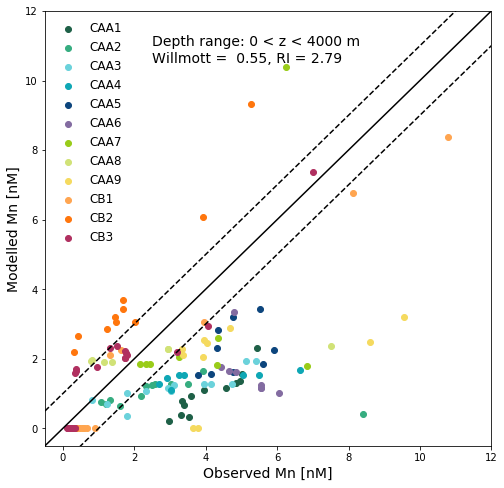

In [31]:
WI_all, RI_all, N_all = scatter_plot(0, 4000, plot=True)
print('WI: ', WI_all, ', RI: ',RI_all, ', N: ', N_all)

WI:  0.5487879275384362 , RI:  2.7916071594679397 , N:  137


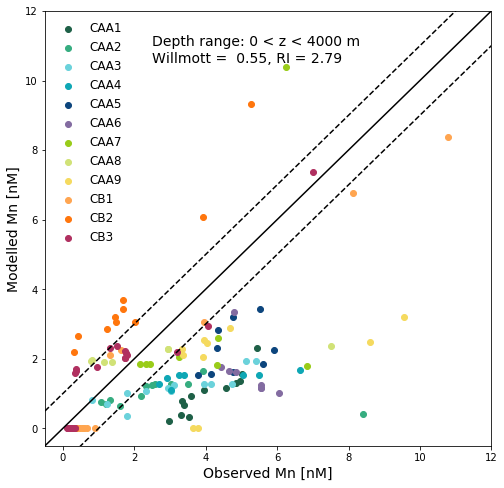

In [32]:
WI_all, RI_all, N_all = scatter_plot(0, 4000, plot=True)
print('WI: ', WI_all, ', RI: ',RI_all, ', N: ', N_all)

### Check to see whether interpolating the model points to the correct depth makes a difference:

Interpolate 

In [ ]:
def match_depth(depths_stn, depths_model=depths_model):
    depth_k  = search_depth(depths_stn, depths_model)
    
    depths_return=np.array([])
    # depths that I'm interested in for the RI & Willmott index:
    for i in range(0, len(depth_k)):
        if depth_k[i] > 0:
            depths_return =np.append(depths_return, depth_k[i])
            
    depths_return  = [int(k) for k in depths_return]
    return depths_return

In [32]:
depth_CAA1

array([  9.7,  29.8,  44. ,  59.9,  80.5, 100.7, 121.2, 150.6, 201.3,
       300.7, 402.4, 603.5])

In [33]:
depths_model

array([4.9402538e-01, 1.5413754e+00, 2.6456685e+00, 3.8194947e+00,
       5.0782237e+00, 6.4406142e+00, 7.9295602e+00, 9.5729971e+00,
       1.1405003e+01, 1.3467138e+01, 1.5810073e+01, 1.8495560e+01,
       2.1598816e+01, 2.5211409e+01, 2.9444729e+01, 3.4434155e+01,
       4.0344051e+01, 4.7373688e+01, 5.5764290e+01, 6.5807274e+01,
       7.7853851e+01, 9.2326073e+01, 1.0972928e+02, 1.3066599e+02,
       1.5585072e+02, 1.8612556e+02, 2.2247517e+02, 2.6604025e+02,
       3.1812744e+02, 3.8021301e+02, 4.5393774e+02, 5.4108893e+02,
       6.4356683e+02, 7.6333307e+02, 9.0233929e+02, 1.0624397e+03,
       1.2452911e+03, 1.4522510e+03, 1.6842844e+03, 1.9418934e+03,
       2.2250779e+03, 2.5333362e+03, 2.8657026e+03, 3.2208203e+03,
       3.5970320e+03, 3.9924839e+03, 4.4052241e+03, 4.8332905e+03,
       5.2747842e+03, 5.7279165e+03], dtype=float32)

In [34]:
stn_model_dmn.shape

(12, 50)

In [36]:
from scipy import interpolate

In [ ]:
for station in stations:
    k_station     = match_depth(depth_station)
    model_dmn_stn = stn_model_dmn[stn,k]*10**9
    
    # interpolate model points to observed depth points
>>> x = np.arange(0, 10)
>>> y = np.exp(-x/3.0)
>>> f = interpolate.interp1d(x, y)
    

In [ ]:
dMn_CAA1[0,:]

(600, -20)

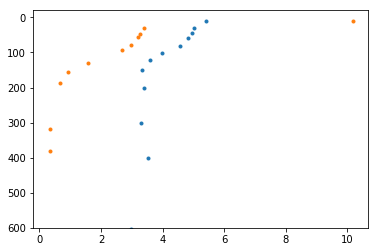

In [56]:
plt.plot(dMn_CAA1, depth_CAA1, '.')
plt.plot(model_dmn_CAA1 , model_depth_CAA1, '.')
plt.gca().invert_yaxis()
plt.ylim([600, -20])

In [ ]:
k_CAA1 = match_depth(depth_CAA1)
k_CAA2 = match_depth(depth_CAA2)
k_CAA3 = match_depth(depth_CAA3)
k_CAA4 = match_depth(depth_CAA4)
k_CAA5 = match_depth(depth_CAA5)
k_CAA6 = match_depth(depth_CAA6)
k_CAA7 = match_depth(depth_CAA7)
k_CAA8 = match_depth(depth_CAA8)
k_CAA9 = match_depth(depth_CAA9)

k_CB1 = match_depth(depth_CB1)
k_CB2 = match_depth(depth_CB2)
k_CB3 = match_depth(depth_CB3)

In [ ]:
model_depth_CAA1 = [depths_model[k] for k in k_CAA1]
model_depth_CAA2 = [depths_model[k] for k in k_CAA2]
model_depth_CAA3 = [depths_model[k] for k in k_CAA3]
model_depth_CAA4 = [depths_model[k] for k in k_CAA4]
model_depth_CAA5 = [depths_model[k] for k in k_CAA5]
model_depth_CAA6 = [depths_model[k] for k in k_CAA6]
model_depth_CAA7 = [depths_model[k] for k in k_CAA7]
model_depth_CAA8 = [depths_model[k] for k in k_CAA8]
model_depth_CAA9 = [depths_model[k] for k in k_CAA9]
model_depth_CB1 = [depths_model[k] for k in k_CB1]
model_depth_CB2 = [depths_model[k] for k in k_CB2]
model_depth_CB3 = [depths_model[k] for k in k_CB3]

In [ ]:
model_dmn_CAA1 = [stn_model_dmn[0,k]*10**9 for k in k_CAA1]
model_dmn_CAA2 = [stn_model_dmn[1,k]*10**9 for k in k_CAA2]
model_dmn_CAA3 = [stn_model_dmn[2,k]*10**9 for k in k_CAA3]
model_dmn_CAA4 = [stn_model_dmn[3,k]*10**9 for k in k_CAA4]
model_dmn_CAA5 = [stn_model_dmn[4,k]*10**9 for k in k_CAA5]
model_dmn_CAA6 = [stn_model_dmn[5,k]*10**9 for k in k_CAA6]
model_dmn_CAA7 = [stn_model_dmn[6,k]*10**9 for k in k_CAA7]
model_dmn_CAA8 = [stn_model_dmn[7,k]*10**9 for k in k_CAA8]
model_dmn_CAA9 = [stn_model_dmn[8,k]*10**9 for k in k_CAA9]
model_dmn_CB1  = [stn_model_dmn[9,k]*10**9 for k in k_CB1]
model_dmn_CB2  = [stn_model_dmn[10,k]*10**9 for k in k_CB2]
model_dmn_CB3  = [stn_model_dmn[11,k]*10**9 for k in k_CB3]

# Assess the Reliability Index

Reliability Index, RI (Leggett and Williams, 1981) --- “quantifies the average factor by which model predictions differ from observations” (Stow et al., 2009). It is in essence the root-mean-square deviation, but it uses the logarithm of the residual. This is useful when both large and small values need to be considered [Van Hulten et al., 2017].

\begin{equation}
RI = exp \sqrt{\frac{1}{N} \sum^N_{i=1}{\bigg(log \frac{O_i}{P_i}\bigg)^2}}
\end{equation}

where $O_i$ is the measured concentration with index i, $P_i$ is the model prediction associated to the respective observation i, and N is the number of observations.

Willmott skill score:

\begin{equation}
IA = 1 - \frac{\big\langle (P_i - O_i)^2 \big\rangle}{\big\langle (| P_i - \langle P_i \rangle | + | O_i - \langle O_i \rangle |)^2 \big\rangle}
\end{equation}

All scores based on the monthly modeled Mn averaged for September (index 8):

| Run       | RI   | Willmott | N    | Components not included |
|-----------|------|----------|------|-------------------------|
| mn_test1a | 2.15 |   0.72   | 128  |  Dust, ice, bio         |
| mn_test1b | 2.17 |   0.76   | 128  |  Dust, bio              |
| mn_test1c | 2.18 |   0.64   | 128  |  Scavenging, bio        |
| mn_test1d | 2.16 |   0.75   | 128  |  Rivers, bio            |
| mn_test1e | 2.15 |   0.76   | 128  |  Sediment diffusion, bio|
| mn_test1f | 2.17 |   0.76   | 128  |  Bio                    |  

Based on these numbers, it is clear that scavenging is an important component for accurately modeling the Mn concentrations. Ice is relatively more important than dust in improving the predictions. River influence at the station locations may not be that important for the comparison. mn_test1f or mn_test1e seems best so far. 

Components that don't really seem to make a significant difference are: sediment diffusion, dust, rivers(?). That mostly agrees with the testing/monthly_component_contribution findings.

A similar table, but for only the surface-intermediate water (top 330 m):

| Run       | RI   | Willmott | N    | Components not included |
|-----------|------|----------|------|-------------------------|
| mn_test1a | 1.99 |   0.52   | 101  |  Dust, ice, bio         |
| mn_test1b | 2.05 |   0.66   | 101  |  Dust, bio              |
| mn_test1c | 2.03 |   0.30   | 101  |  Scavenging, bio        |
| mn_test1d | 2.02 |   0.64   | 101  |  Rivers, bio            |
| mn_test1e | 2.03 |   0.67   | 101  |  Sediment diffusion, bio|
| mn_test1f | 2.05 |   0.66   | 101  |  Bio                    |  

And for intermediate-deep waters (below 330 m):

| Run       | RI   | Willmott | N    | Components not included |
|-----------|------|----------|------|-------------------------|
| mn_test1a | 5.69 |   0.15   | 15   |  Dust, ice, bio         |
| mn_test1b | 5.69 |   0.15   | 15   |  Dust, bio              |
| mn_test1c | 5.72 |   0.16   | 15   |  Scavenging, bio        |
| mn_test1d | 5.69 |   0.15   | 15   |  Rivers, bio            |
| mn_test1e | 5.58 |   0.13   | 15   |  Sediment diffusion, bio|
| mn_test1f | 5.70 |   0.15   | 15   |  Bio                    |  

# Other observations:

#### Campbell and Yeats, 1982: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.896.6307&rep=rep1&type=pdf

In [7]:
lat_1982 = [66.7567, 66.7483, 72.235, 74.333, 74.1783, 76.35167, 76.393, 78.32, 78.315, 66.7583]
lon_1982 = [-57.095, -60.25167, -65.9483, -94.263, -94.2433, -89.43, -89.305, -74.7167, \
           -74.2667, -57.0617]

# total manganese, not specifically dissolved:
tMn_1982_stn1  = [0.26, 0.10, 0.05, 0.06]
tMn_1982_stn2  = [0.10, 0.12, 0.20, 0.17, 0.22, 0.20]
tMn_1982_stn3  = [0.38, 0.33, 0.27, 0.34, 0.25, 0.23, 0.24, 0.27, 0.28, 0.21, 0.24, 0.16, \
                  0.21, 0.27, 0.17, 0.13, 0.15, 0.24, 0.11]
dMn_1982_stn3  = [0.20, 0.24, np.NaN, 0.29, 0.20, 0.17, 0.17, 0.19, 0.20, 0.16, 0.22, 0.08, \
                  0.14, 0.11, 0.10, 0.06, 0.13, 0.09, 0.09]
tMn_1982_stn4  = [0.30, 0.27, 0.23, 0.28, 0.38]
tMn_1982_stn5  = [0.31, 0.29, 0.33, 0.29, 0.33]
tMn_1982_stn6  = [0.56, 0.36, 0.22]
tMn_1982_stn7  = [0.40, 0.38, 0.32]
tMn_1982_stn8  = [0.19, 0.15, 0.17, 0.16, 0.14, 0.21, 0.16]
tMn_1982_stn9  = [0.32, 0.33, 0.19, 0.13, 0.12, 0.17, 0.18, 0.19]
tMn_1982_stn10 = [0.14, 0.15, 0.14, 0.13, 0.13, 0.10, 0.11, 0.12, 0.12, 0.13]

depths_1982_stn1  = [10, 75, 250, 400]
depths_1982_stn2  = [12, 20, 50, 110, 250, 505]
depths_1982_stn3  = [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 250, 500, 800, 1000, 1200, 1500, 1750, 2000, 2300]
depths_1982_stn4  = [10, 20, 50, 100, 150]
depths_1982_stn5  = [10, 20, 50, 100, 140]
depths_1982_stn6  = [10, 25, 75]
depths_1982_stn7  = [9, 20, 75]
depths_1982_stn8  = [15, 25, 50, 100, 200, 300, 400]
depths_1982_stn9  = [10, 20, 50, 100, 210, 305, 405, 500]
depths_1982_stn10 = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

#### Cid et al., 2012: https://link.springer.com/content/pdf/10.1007%2Fs10872-012-0150-8.pdf

Stations don't really fall within my sub-domain, so probably won't use.

#### Yeats and Westerlund, 1991: https://ac.els-cdn.com/0304420391900714/1-s2.0-0304420391900714-main.pdf?_tid=12ba389d-4f68-4967-bad0-2103cfe975e1&acdnat=1552929800_480578b2e506b2c3c50d3c44ef66221e

Samples collected in June, 1985 at a land-fast ice island.

In [8]:
lat_1991   = [81.723]
lon_1991   = [-93.4167]
depth_1991 = [60, 80, 80, 90, 100, 100, 110, 120, 150, 200, 270, 280]
dMn_1991   = [2.11, 1.35, 1.33, 1.22, 1.18, 1.89, 1.36, 1.27, 0.55, 0.62, 1.58, 0.51] #unfiltered

#### Yeats, 1988: https://archimer.ifremer.fr/doc/00106/21767/19341.pdf

stations drifted for ~80 km between first and last measurement. Samples collected in 1981 and 1983, not sure which month. Stn 1 is out of domain, so only look at station 2.

In [9]:
lat_1988        = [86]   #[82, 86]
lon_1988        = [-111] #[6, -111]
#dMn_1988_stn1   = [6.5, 3.9, 4.9, 4.1, 3.6, 5.2, 4.0, 4.9, 3.0, 2.9, 2.5, 3.3, 1.8, 3.4, 3.0, 6.3, 5.2, 2.8]
dMn_1988_stn2   = [2.2, 1.6, 2.2, 1.1, 0.7, 1.3, 0.5, 0.5, 0.2, 0.6, 0.2, 0.4, 0.45, 0.5, 0.8, 0.4, 0.3, 0.3]
#depth_1988_stn1 = [5, 10, 20, 35, 50, 75, 85, 90, 100, 175, 225, 300, 500, 775, 1000, 1800, 2000, 2500]
depth_1988_stn2 = [5, 10, 50, 80, 100, 150, 220, 250, 280, 350, 380, 410, 600, 800, 1000, 1250, 1350, 1375]

#### USGS Arctic Ocean Carbon Cruise 2012: https://pubs.usgs.gov/ds/0862/html/ds862_maps.html
in folder: /Research/Data/BCs. I'm unclear about at what depths these measurements were taken.

In [10]:
data = pd.read_csv("/ocean/brogalla/GEOTRACES/data/HLY1202_Metals_Profile.csv") 

In [11]:
lat_2012 = np.array(data.get('Latitude_(Decimal_Degrees)'))
lon_2012 = np.array(data.get('Longitude_(Decimal_Degrees)'))
dMn_2012 = np.array(data.get('Mn_ug/L'))

Station locations:

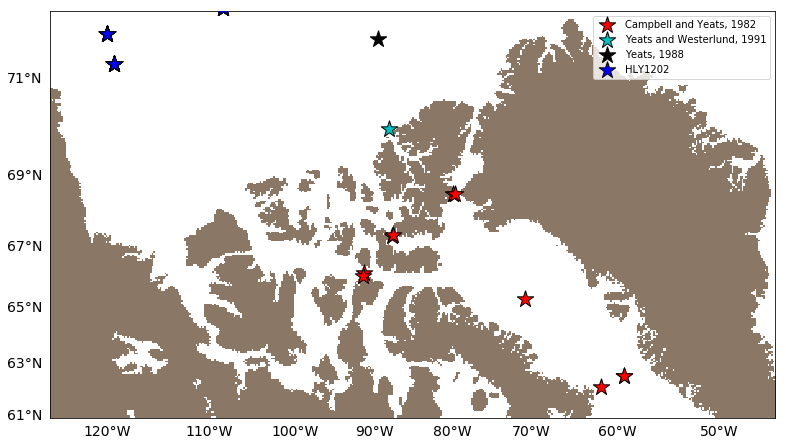

In [12]:
fig,ax = plt.subplots(figsize=(13,8))

proj=Basemap(projection='stere',lat_0 = 77.5, lon_0 = -85, resolution='i', width=4.1e6, height=2.3e6)
proj.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)
proj.drawlsmask(land_color = "#8b7765", ocean_color="none", resolution = 'l')

x_1982, y_1982 = proj(lon_1982, lat_1982)
x_1991, y_1991 = proj(lon_1991, lat_1991)
x_1988, y_1988 = proj(lon_1988, lat_1988)
x_2012, y_2012 = proj(lon_2012, lat_2012)
proj.scatter(x_1982, y_1982, color='r', marker='*',s=300,zorder=3, edgecolor='k', label='Campbell and Yeats, 1982')  
proj.scatter(x_1991, y_1991, color='c', marker='*',s=300,zorder=3, edgecolor='k', label='Yeats and Westerlund, 1991')  
proj.scatter(x_1988, y_1988, color='k', marker='*',s=300,zorder=3, edgecolor='k', label='Yeats, 1988')  
proj.scatter(x_2012, y_2012, color='b', marker='*',s=300,zorder=3, edgecolor='k', label='HLY1202')  
ax.legend(loc=1)

## Compare Campbell & Yeats, 1982 with GEOTRACES stations

Units Campbell & Yeats: micro gram/L

\begin{equation}
 \frac{g}{L} = 54.9380450 \frac{g}{mol} \frac{mol}{L} = M
\end{equation}

In [ ]:
colors_g = ['#00b3b3', '#82e1b3', '#eccaab']
colors_1982 = ['#4076a9', '#003865']

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(13,8))

ax[0].invert_yaxis()

j=0
for i in [6, 7, 4]:
    dMn   = transect_dMn[:,i]
    depth = transect_depths[:,i]
    ax[0].plot(dMn, depth, c=colors_g[j], zorder=1, label=transect_names[i])
    ax[0].scatter(dMn, depth, c=colors_g[j], zorder=2, edgecolor='k')
    j+=1

umn = 54.9380450 #molar weight Mn
ax[0].plot([i*10**3/umn for i in tMn_1982_stn4], depths_1982_stn4, zorder=3, \
           label='Stn 4', c=colors_1982[0], linewidth=2.5)
ax[0].scatter([i*10**3/umn for i in tMn_1982_stn4], depths_1982_stn4, zorder=4, \
              c=colors_1982[0], edgecolor='k')
ax[0].plot([i*10**3/umn for i in tMn_1982_stn5], depths_1982_stn5, zorder=3, \
           label='Stn 5', c=colors_1982[1], linewidth=2.5)    
ax[0].scatter([i*10**3/umn for i in tMn_1982_stn5], depths_1982_stn5, zorder=4, \
              c=colors_1982[1], edgecolor='k')    

ax[0].set_xlabel('Dissolved Mn [nM]')
ax[0].set_ylabel('Depth [m]')
ax[0].xaxis.tick_top()    
ax[0].xaxis.set_label_position('top') 
ax[0].legend(loc=4)

# map:
proj=Basemap(projection='stere',lat_0 = 75, lon_0 = -90, resolution='i', width=1.1e6, height=1e6, ax=ax[1])
proj.drawlsmask(land_color = "#8b7765", ocean_color="none", resolution = 'h')
proj.drawcoastlines()

x_GEOTRACES, y_GEOTRACES = proj(transect_lons, transect_lats)
proj.scatter(x_GEOTRACES[6], y_GEOTRACES[6], color=colors_g[0], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA4')  
proj.scatter(x_GEOTRACES[7], y_GEOTRACES[7], color=colors_g[1], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA5')  
proj.scatter(x_GEOTRACES[4], y_GEOTRACES[4], color=colors_g[2], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA6')  

x_1982, y_1982 = proj(lon_1982, lat_1982)
proj.scatter(x_1982[3], y_1982[3], color=colors_1982[0], marker='*',s=300,zorder=3, edgecolor='k', \
             label='Campbell & Yeats 1982, Stn 4')  
proj.scatter(x_1982[4], y_1982[4], color=colors_1982[1], marker='*',s=300,zorder=2, edgecolor='k', \
             label='Campbell & Yeats 1982, Stn 5')  
ax[1].legend(framealpha=1)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(13,8))

ax[0].invert_yaxis()

j=0
for i in [6, 7, 4]:#range(4, 8):
    dMn   = transect_dMn[:,i]
    depth = transect_depths[:,i]
    #if i != 5:
    ax[0].plot(dMn, depth, c=colors_g[j], zorder=2, label=transect_names[i], linewidth=4)
    ax[0].scatter(dMn, depth, c=colors_g[j], zorder=3, edgecolor='k')
    j+=1  

# add in model profiles at these points:
model_CAA4i, model_CAA4j = find_index_ANHA12_sub(transect_lons[6], transect_lats[6])
model_CAA5i, model_CAA5j = find_index_ANHA12_sub(transect_lons[7], transect_lats[7])
model_CAA6i, model_CAA6j = find_index_ANHA12_sub(transect_lons[4], transect_lats[4])
mn_mCAA4 = mn_dis[10,0,:,model_CAA4i,model_CAA4j]*10**9
mn_mCAA4[mn_mCAA4 == 0] = np.nan
mn_mCAA5 = mn_dis[10,0,:,model_CAA5i,model_CAA5j]*10**9
mn_mCAA5[mn_mCAA5 == 0] = np.nan
mn_mCAA6 = mn_dis[10,0,:,model_CAA6i,model_CAA6j]*10**9
mn_mCAA6[mn_mCAA6 == 0] = np.nan
ax[0].plot(mn_mCAA4, depths_model, zorder=1, linestyle='--', label='Model CAA4', c=colors_g[0], linewidth=2.5)    
ax[0].plot(mn_mCAA5, depths_model, zorder=1, linestyle='--', label='Model CAA5', c=colors_g[1], linewidth=2.5)      
ax[0].plot(mn_mCAA6, depths_model, zorder=1, linestyle='--', label='Model CAA6', c=colors_g[2], linewidth=2.5)      
    
ax[0].set_xlabel('Dissolved Mn [nM]')
ax[0].set_ylabel('Depth [m]')
ax[0].set_ylim([250, 0])
ax[0].xaxis.tick_top()    
ax[0].xaxis.set_label_position('top') 
ax[0].legend(loc=4)

# map:
proj=Basemap(projection='stere',lat_0 = 75, lon_0 = -90, resolution='i', width=1.1e6, height=1e6, ax=ax[1])
proj.drawlsmask(land_color = "#8b7765", ocean_color="none", resolution = 'h')
proj.drawcoastlines()

x_GEOTRACES, y_GEOTRACES = proj(transect_lons, transect_lats)
proj.scatter(x_GEOTRACES[6], y_GEOTRACES[6], color=colors_g[0], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA4')  
proj.scatter(x_GEOTRACES[7], y_GEOTRACES[7], color=colors_g[1], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA5')  
proj.scatter(x_GEOTRACES[4], y_GEOTRACES[4], color=colors_g[2], marker='*',s=300,zorder=3, edgecolor='k', \
            label='CAA6')  
ax[1].legend(framealpha=1)